importing the required libraries

In [37]:
from collections import Counter, OrderedDict

import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm
import os, shutil, random

In [ ]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    while isinstance(dataset, torch.utils.data.Subset):
        dataset = dataset.dataset
    class_to_index = dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

converting all images to rgb format

In [2]:
class ToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

a basic Compose of transforms to apply on images

In [59]:
from PIL import Image
import numpy as np

x = Image.open('../data/train/angry/frame_2.jpg')
np.array(x).shape

(480, 640, 3)

In [66]:
transform = transforms.Compose([
    transforms.CenterCrop((400, 400)),
    transforms.Resize((224, 224)),
    ToRGB(),
    transforms.ToTensor()
])

In [39]:
# paths to the data directories
data_dir = Path('..', 'data')
collected_dir = data_dir / 'collected'
train_dir = data_dir / 'train'
test_dir = data_dir / 'val'

train_dir.mkdir(exist_ok=True)
test_dir.mkdir(exist_ok=True)

In [40]:
emotions_paths = list(collected_dir.iterdir())
for path in emotions_paths:
    files = list(path.iterdir())
    split = int(0.8 * len(files))
    random.shuffle(files)
    training = files[:split]
    testing = files[split:]

    (train_dir / path.name).mkdir(parents=True, exist_ok=True)
    (test_dir / path.name).mkdir(parents=True, exist_ok=True)

    for train_file in training:
        old_dir = path / train_file.name
        new_dir = train_dir / path.name / train_file.name
        shutil.move(old_dir, new_dir)

    for test_file in testing:
        old_dir = path / test_file.name
        new_dir = test_dir / path.name / test_file.name
        shutil.move(old_dir, new_dir)

reading in the data using ImageFolder method from pytorch datasets and creating a Dataloader object 

In [67]:
train_dataset = datasets.ImageFolder(train_dir, transform = transform)
test_dataset = datasets.ImageFolder(test_dir, transform = transform)

print(f'training data total length {len(train_dataset)}')
print(f'evaluating data total length {len(test_dataset)}')

classes = train_dataset.classes

training data total length 144
evaluating data total length 37


In [79]:
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)


displaying a random picture from the data loader

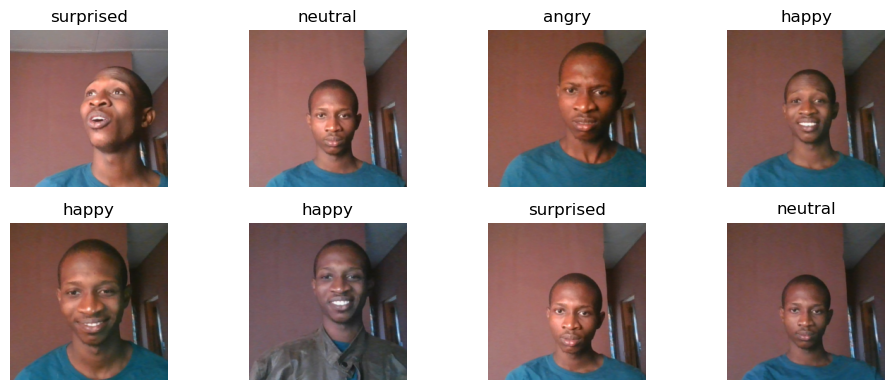

In [80]:
fig, ax = plt.subplots(2, 4, figsize=(10, 4))

train_iter = iter(train_loader)
train_batch = next(train_iter)
train_images, train_labels = train_batch[0], train_batch[1]

for i in range(4):
    ex = train_images[i]
    lbl = train_labels[i].item()
    im = ex.permute(1, 2, 0).numpy()

    ax[0, i].imshow(im)
    ax[0, i].axis('off')
    ax[0, i].set_title(classes[lbl])

test_iter = iter(test_loader)
test_batch = next(test_iter)
test_images, test_labels = test_batch[0], test_batch[1]

for i in range(4):
    ex = test_images[i]
    lbl = test_labels[i].item()
    im = ex.permute(1, 2, 0).numpy()

    ax[1, i].imshow(im)
    ax[1, i].axis('off')
    ax[1, i].set_title(classes[lbl])

plt.tight_layout()
plt.show()


adding a normalizing transform to the transform Compose to maintain the right range of values

In [82]:
def get_mean_std(loader):
    count, batchsum, squaredbatchsum = 0, 0, 0
    for data, _ in tqdm(loader):
        batchsum += torch.mean(data, dim = [0, 2, 3])
        squaredbatchsum += torch.mean(data **2, dim =  [0, 2, 3])
        count += 1
    
    mean = batchsum / count
    std = (squaredbatchsum / count - mean**2) ** 0.5
    
    return mean, std
mean, std = get_mean_std(train_loader)
print(f"mean: {mean}")
print(f"std: {std}")

  0%|          | 0/15 [00:00<?, ?it/s]

mean: tensor([0.3948, 0.3032, 0.2883])
std: tensor([0.1745, 0.1102, 0.1303])


In [83]:
norm_transform = transforms.Compose([
    transforms.CenterCrop((400, 400)),
    transforms.Resize((220, 220)),
    ToRGB(),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])

In [ ]:
train_norm_dataset = datasets.ImageFolder(train_dir, transform = norm_transform)
test_norm_dataset = datasets.ImageFolder(test_dir, transform = norm_transform)

In [91]:
test_norm_loader = DataLoader(test_norm_dataset, batch_size = 10, shuffle = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


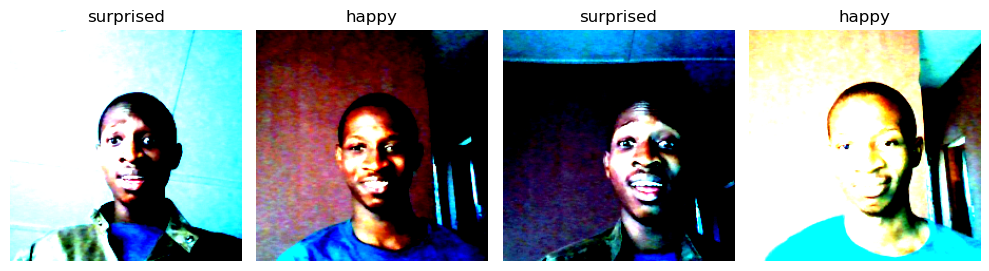

In [92]:
fig, ax = plt.subplots(1, 4, figsize=(10, 4))

test_iter = iter(test_norm_loader)
test_batch = next(test_iter)
test_images, test_labels = test_batch[0], test_batch[1]

for i in range(4):
    ex = test_images[i]
    lbl = test_labels[i].item()
    im = ex.permute(1, 2, 0).numpy()

    ax[i].imshow(im)
    ax[i].axis('off')
    ax[i].set_title(classes[lbl])

plt.tight_layout()
plt.show()


splitting into training and validating data

In [95]:
train_dataset, val_dataset = random_split(train_norm_dataset, lengths = (0.8, 0.2))

checking the count of the classes represented in each of training and validating data

  0%|          | 0/116 [00:00<?, ?it/s]

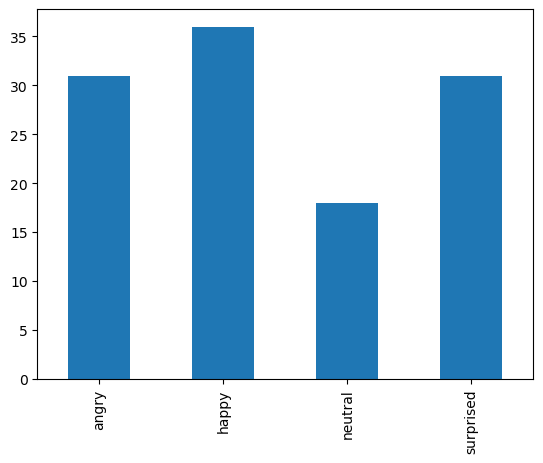

  0%|          | 0/28 [00:00<?, ?it/s]

<Axes: >

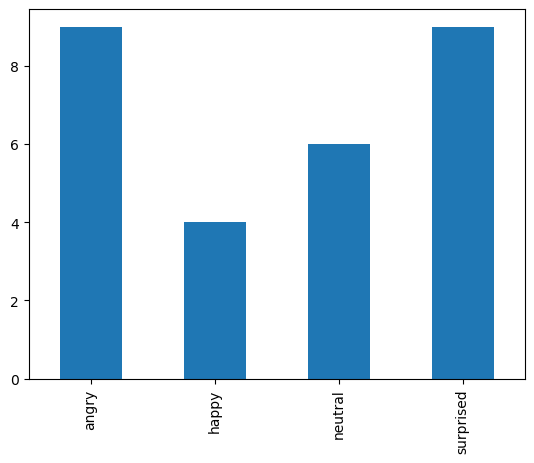

In [97]:
class_counts(train_dataset).plot(kind = 'bar')
plt.show()
class_counts(val_dataset).plot(kind = 'bar')

In [106]:
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size)

defining the model architecture

In [114]:
model = torch.nn.Sequential(OrderedDict([
    ("conv1", torch.nn.Conv2d(in_channels=3, out_channels=256, kernel_size=(3, 3), stride=1, padding=1)),
    ("pool1", torch.nn.MaxPool2d(kernel_size=(2, 2))),
    ("relu1", torch.nn.ReLU()),

    ("conv2", torch.nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3))),
    ("pool2", torch.nn.MaxPool2d(kernel_size=(2, 2))),
    ("relu2", torch.nn.ReLU()),

    ("conv3", torch.nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3))),
    ("pool3", torch.nn.MaxPool2d(kernel_size=(2, 2))),
    ("relu3", torch.nn.ReLU()),

    ("flatten", torch.nn.Flatten()),
    ("fc", torch.nn.Linear(in_features=64 * 26 * 26, out_features=4))
]))


setting the loss function and the optimizer

In [108]:
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 10

In [109]:
def score(model, data_loader, loss_fn, device="cpu"):
    total_loss = 0
    total_correct = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            targets = targets.to(device)
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)

            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()
    average_loss = total_loss / len(data_loader.dataset)
    accuracy = total_correct / len(data_loader.dataset)
    return average_loss, accuracy

training the model

In [115]:
losses = []
for epoch in range(epochs):
    for data, labels in tqdm(train_loader):
        optim.zero_grad()

        output = model(data)
        loss = loss_fn(output, labels)

        loss.backward()
        optim.step()
        losses.append(loss.item())


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

visualizing the training loss 

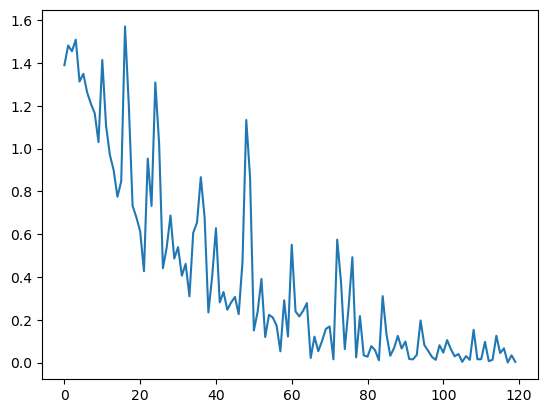

In [102]:
plt.plot(losses)

evaluating the model on the validation data

In [103]:
val_losses = []
val_accuracy = []
with torch.no_grad():
    count = 0
    for images, labels in tqdm(val_loader):
        output = model(images)
        count += 1
        loss = loss_fn(output, labels)
        val_losses.append(loss.item())
        print(count)

        correct = torch.eq(torch.argmax(output, dim = 1), labels)
        total_correct = torch.sum(correct).item()
        accuracy = total_correct / len(val_loader.dataset)
        val_accuracy.append(accuracy)

  0%|          | 0/3 [00:00<?, ?it/s]

1
2
3


In [104]:
# plt.plot(val_losses)
val_losses

[1.4890503883361816, 0.8360480070114136, 0.11831263452768326]

In [105]:
accuracy

0.25

In [111]:
validation_loss, validation_accuracy = score(model, train_loader, loss_fn)
validation_accuracy, validation_loss

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

(0.31896551724137934, 1.3895681705968133)